# Logistic regression with L2 regularization 

### Predicting sentiment from product reviews

This notebook builds on Coursera course: Machine Learning: Classification (week2)

It demonstrates appilication of logistic regression, **focusing on the impact of L2 regularization.** The dataflow is almost identical as in the notebook logistic_regression_numpy.ipnyb.

It includes L2 regularization the following functions:

 * feature_derivative_with_L2
 
 * compute_log_likelihood_with_L2
 
 #### L2 norm
![title](50aa64b52c9ebd19d47552eae57ec4a05cf43e67.svg)
 
 ![title](logistic_regression_from_scratch_L2.png)
 
 

### libraries

In [2]:
import pandas as pd
import string
import json
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

### functions

In [3]:
def load_dataset_from_csv(path_to_dataset,data_types_ditc):
    dataset = pd.read_csv(path_to_dataset,dtype=data_types_ditc)
    return dataset

In [4]:
def remove_na(dataset,column):
    print("n/a before: " + str(dataset[column].isnull().sum()))
    dataset[column].fillna('',inplace = True)
    print("n/a before: " + str(dataset[column].isnull().sum()))

In [5]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '',string.punctuation))

In [6]:
def read_json(json_path):
    f = open(json_path)
    data = json.load(f)
    f.close()
    return data

In [7]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.to_numpy()
    label_sarray = dataframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [8]:
def predict_probability(feature_matrix, coefficients):
    '''P(y_i = +1 | x_i, w)'''
    scores = np.dot(feature_matrix,coefficients)
    predictions = 1. / (1 + np.exp(-scores))
    return predictions

In [9]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)
    # if feature not constant add L2 penalty
    if not feature_is_constant: 
        derivative = derivative - (2 * l2_penalty * coefficient)
        
    return derivative

In [10]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    return lp

In [11]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) 
    for itr in range(max_iter):
   
        predictions = predict_probability(feature_matrix, coefficients)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            coefficients[j] += step_size * derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print ('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

In [12]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

### Load and clean dataset

In [13]:
products = pd.read_csv('amazon_baby_subset.csv')

In [14]:
products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [15]:
products['sentiment'].value_counts()

 1    26579
-1    26493
Name: sentiment, dtype: int64

In [16]:
products.isna().sum()

name          90
review       241
rating         0
sentiment      0
dtype: int64

In [17]:
remove_na(products,'review')

n/a before: 241
n/a before: 0


In [18]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [19]:
products.head()

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...


### count words and prepare word count matrices for train / test

In [20]:
important_words = read_json('important_words.json')

In [21]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))
    

/tmp/ipykernel_9479/1448526264.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  products[word] = products['review_clean'].apply(lambda s : s.split().count(word))


In [22]:
products_df = products.copy()

In [23]:
train_indicies = read_json('module-4-assignment-train-idx.json')
validation_indicies = read_json('module-4-assignment-validation-idx.json')

In [24]:
train_data = products_df.iloc[train_indicies]

In [25]:
validation_data = products_df.iloc[validation_indicies]

In [26]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

/tmp/ipykernel_9479/77861227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['constant'] = 1


### train models with different penalties

In [27]:
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

In [28]:
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39508175
iteration   1: log likelihood of observed labels = -29003.73417180
iteration   2: log likelihood of observed labels = -28834.71441858
iteration   3: log likelihood of observed labels = -28671.80345068
iteration   4: log likelihood of observed labels = -28514.58077957
iteration   5: log likelihood of observed labels = -28362.69830317
iteration   6: log likelihood of observed labels = -28215.85663259
iteration   7: log likelihood of observed labels = -28073.79071393
iteration   8: log likelihood of observed labels = -27936.26093762
iteration   9: log likelihood of observed labels = -27803.04751805
iteration  10: log likelihood of observed labels = -27673.94684207
iteration  11: log likelihood of observed labels = -27548.76901327
iteration  12: log likelihood of observed labels = -27427.33612958
iteration  13: log likelihood of observed labels = -27309.48101569
iteration  14: log likelihood of observed labels = -27195.0462

In [29]:
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.40062984
iteration   1: log likelihood of observed labels = -29003.76654163
iteration   2: log likelihood of observed labels = -28834.79322654
iteration   3: log likelihood of observed labels = -28671.94687528
iteration   4: log likelihood of observed labels = -28514.80571589
iteration   5: log likelihood of observed labels = -28363.02048079
iteration   6: log likelihood of observed labels = -28216.29071186
iteration   7: log likelihood of observed labels = -28074.35036891
iteration   8: log likelihood of observed labels = -27936.95892966
iteration   9: log likelihood of observed labels = -27803.89576265
iteration  10: log likelihood of observed labels = -27674.95647005
iteration  11: log likelihood of observed labels = -27549.95042714
iteration  12: log likelihood of observed labels = -27428.69905549
iteration  13: log likelihood of observed labels = -27311.03455140
iteration  14: log likelihood of observed labels = -27196.7989

In [30]:
coefficients_100_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=100, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.48385120
iteration   1: log likelihood of observed labels = -29004.25177457
iteration   2: log likelihood of observed labels = -28835.97382190
iteration   3: log likelihood of observed labels = -28674.09410083
iteration   4: log likelihood of observed labels = -28518.17112932
iteration   5: log likelihood of observed labels = -28367.83774654
iteration   6: log likelihood of observed labels = -28222.77708939
iteration   7: log likelihood of observed labels = -28082.70799392
iteration   8: log likelihood of observed labels = -27947.37595368
iteration   9: log likelihood of observed labels = -27816.54738615
iteration  10: log likelihood of observed labels = -27690.00588850
iteration  11: log likelihood of observed labels = -27567.54970126
iteration  12: log likelihood of observed labels = -27448.98991327
iteration  13: log likelihood of observed labels = -27334.14912742
iteration  14: log likelihood of observed labels = -27222.8604

In [31]:
coefficients_1000_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=1000, max_iter=501)

iteration   0: log likelihood of observed labels = -29180.31606471
iteration   1: log likelihood of observed labels = -29009.07176112
iteration   2: log likelihood of observed labels = -28847.62378912
iteration   3: log likelihood of observed labels = -28695.14439397
iteration   4: log likelihood of observed labels = -28550.95060743
iteration   5: log likelihood of observed labels = -28414.45771129
iteration   6: log likelihood of observed labels = -28285.15124375
iteration   7: log likelihood of observed labels = -28162.56976044
iteration   8: log likelihood of observed labels = -28046.29387744
iteration   9: log likelihood of observed labels = -27935.93902900
iteration  10: log likelihood of observed labels = -27831.15045502
iteration  11: log likelihood of observed labels = -27731.59955260
iteration  12: log likelihood of observed labels = -27636.98108219
iteration  13: log likelihood of observed labels = -27547.01092670
iteration  14: log likelihood of observed labels = -27461.4242

In [32]:
coefficients_100000_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=100000, max_iter=501)

iteration   0: log likelihood of observed labels = -29271.85955115
iteration   1: log likelihood of observed labels = -29271.71006589
iteration   2: log likelihood of observed labels = -29271.65738833
iteration   3: log likelihood of observed labels = -29271.61189923
iteration   4: log likelihood of observed labels = -29271.57079975
iteration   5: log likelihood of observed labels = -29271.53358505
iteration   6: log likelihood of observed labels = -29271.49988440
iteration   7: log likelihood of observed labels = -29271.46936584
iteration   8: log likelihood of observed labels = -29271.44172890
iteration   9: log likelihood of observed labels = -29271.41670149
iteration  10: log likelihood of observed labels = -29271.39403722
iteration  11: log likelihood of observed labels = -29271.37351294
iteration  12: log likelihood of observed labels = -29271.35492661
iteration  13: log likelihood of observed labels = -29271.33809523
iteration  14: log likelihood of observed labels = -29271.3228

### Analyze coefficients

In [33]:
coeff_dict = {'coefficients_0_penalty':coefficients_0_penalty,
              'coefficients_4_penalty':coefficients_4_penalty,
             'coefficients_10_penalty':coefficients_10_penalty,
              'coefficients_100_penalty':coefficients_100_penalty,
             'coefficients_1000_penalty':coefficients_1000_penalty,
             'coefficients_100000_penalty':coefficients_100000_penalty}

In [34]:
coeffs_df = pd.DataFrame.from_dict(coeff_dict)

In [35]:
coeffs_df

,coefficients_0_penalty,coefficients_4_penalty,coefficients_10_penalty,coefficients_100_penalty,coefficients_1000_penalty,coefficients_100000_penalty
0,-0.063742,-0.063143,-0.062256,-0.050438,0.000054,0.011362
1,0.074073,0.073994,0.073877,0.072360,0.059752,0.001784
2,0.012753,0.012495,0.012115,0.007247,-0.008761,-0.001827
3,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950
4,1.058554,1.050856,1.039529,0.896644,0.418354,0.009042
...,...,...,...,...,...,...
189,0.052494,0.052130,0.051594,0.044805,0.021026,0.000365
190,0.004960,0.004907,0.004830,0.003848,0.001084,0.000017
191,-0.166745,-0.165367,-0.163338,-0.137693,-0.054778,-0.000936
192,-0.031916,-0.031621,-0.031186,-0.025604,-0.007361,-0.000125


In [36]:
worst_10_penalty_0 = list(np.array(important_words)[np.argsort(coefficients_0_penalty)-1][:10])
worst_10_penalty_0

['disappointed',
 'money',
 'return',
 'waste',
 'returned',
 'broke',
 'work',
 'thought',
 'idea',
 'cheap']

In [37]:
top_10_penalty_0 = list(np.array(important_words)[np.argsort(coefficients_0_penalty)-1][-10:])

In [38]:
top_10_penalty_0.reverse()
top_10_penalty_0 

['love',
 'loves',
 'easy',
 'perfect',
 'great',
 'happy',
 'best',
 'little',
 'fits',
 'well']

In [39]:
coefficient_indicies = np.append((np.argsort(coefficients_0_penalty)-1)[-5:],(np.argsort(coefficients_0_penalty)-1)[:5] )

In [40]:
np.array(important_words)[coefficient_indicies]

array(['great', 'perfect', 'easy', 'loves', 'love', 'disappointed',
       'money', 'return', 'waste', 'returned'], dtype='<U12')

In [41]:
coeffs_df.iloc[coefficient_indicies]

,coefficients_0_penalty,coefficients_4_penalty,coefficients_10_penalty,coefficients_100_penalty,coefficients_1000_penalty,coefficients_100000_penalty
2,0.012753,0.012495,0.012115,0.007247,-0.008761,-0.001827
33,-0.368678,-0.366362,-0.362954,-0.319905,-0.167569,-0.004365
7,-0.003384,-0.003442,-0.003527,-0.004635,-0.007043,-0.000827
22,-0.013247,-0.013295,-0.013366,-0.014326,-0.015219,-0.000839
3,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950
105,-0.224583,-0.222501,-0.219430,-0.180127,-0.055095,-0.000760
96,0.085189,0.084401,0.083239,0.068363,0.019973,-0.000075
113,-0.617809,-0.612475,-0.604620,-0.505189,-0.190631,-0.003345
112,-0.222762,-0.221059,-0.218552,-0.186712,-0.079192,-0.001429
168,-0.032009,-0.031804,-0.031502,-0.027685,-0.014185,-0.000426


In [42]:
labels_ = top_10_penalty_0[:6] + worst_10_penalty_0[:6]

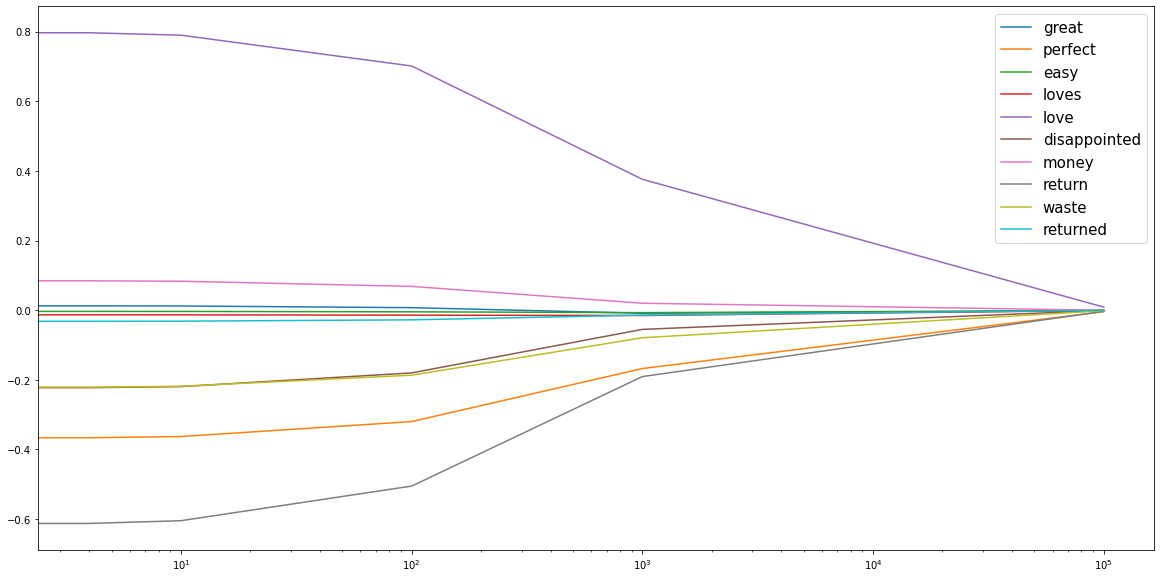

In [43]:
fig, ax = plt.subplots(1,1,figsize = (20,10))

penalty_values = [0,4,10,100,1000,100000]
ax.set_xscale('log')
labels_ = []


for i in coefficient_indicies:
    ax.plot(penalty_values,coeffs_df.iloc[i])
    labels_.append((important_words)[i])
    
ax.legend(labels=labels_,loc = 'upper right',fontsize = 15);




In [44]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_100_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1000_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_100000_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_100_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1000_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_100000_penalty)


In [45]:


# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print ("L2 penalty = %g" % key)
    print ("train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key]))
    print ("--------------------------------------------------------------------------------")






L2 penalty = 0
train accuracy = 0.7851561577866434, validation_accuracy = 0.781439641490057
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.7851089445480512, validation_accuracy = 0.7815330034543927
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.7849909114515711, validation_accuracy = 0.7817197273830642
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.7839758268218409, validation_accuracy = 0.781066193632714
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.7758551497839994, validation_accuracy = 0.7713565493417982
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.6803663747314747, validation_accuracy = 0.667818130893474
-----------------------------

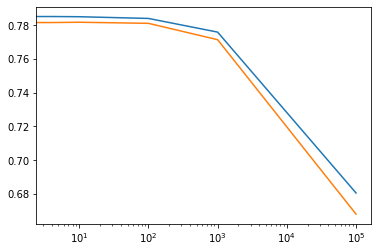

In [46]:
lists = sorted(train_accuracy.items()) # sorted by key, return a list of tuples
lists_1 = sorted(validation_accuracy.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
x1,y1 = zip(*lists_1)

plt.plot(x, y)
plt.plot(x1,y1)
plt.xscale('log')
plt.show()